## Transfer Learning from CNN LSTM


### Method 1
- Data preprocess the same way for input
- Only train the last cnn layer, and freeze the rest


### Bench Marks
**Final Result for Random Forest trained on SOCAT**

Test Set RMSE: 30.56 | Whole Grid Rmse: 42.12


**Final Result for XGBoost trained on SOCAT**

Test Set RMSE:28.43698261274142 | Whole Grid Rmse:37.709863752151215

### Result

Test Set RMSE: 15.368 | Whole Grid RMSE: ~87


In [1]:
import imp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras

%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

import os
tf.random.set_seed(42)


sys.path.insert(0, '../../src')
from utils import df_to_xarray,read_xarray,inverse_scale_image, get_point_prediction

sys.path.insert(0, '../../src/preprocess')
from data_preprocess import preprocess_image_reduced,preprocess_images_nfp

/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2022-02-07 10:51:17.484946: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
import tensorflow.keras.backend as kb
import tensorflow as tf
from tensorflow.keras import backend as K

def custom_rmse(y_true, y_pred):
    """
    custom_rmse(y_true, y_pred)
    calculates root square mean value with focusing only on the ocean
    """
    y_pred = y_pred[y_true != 0]
    y_true = y_true[y_true != 0]
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    
    return K.sqrt(K.mean(tf.math.squared_difference(y_pred, y_true), axis=-1))

In [3]:
dir_name="../../data/data1"
val_dir_name="../../data/data2"

data,pco2 = preprocess_images_nfp(dir_name)
data_socat, pco2_socat = preprocess_images_nfp(dir_name, socat = True)
val_data,val_pco2 = preprocess_images_nfp(val_dir_name,"035")

/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
ecCodes library not found using ['eccodes', 'libeccodes.so', 'libeccodes']
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [23]:
X_index=np.lib.stride_tricks.sliding_window_view(range(421),3) 

y=np.expand_dims(pco2_socat[X_index][1:],axis=4)
X=data_socat[X_index][:-1]
print(X.shape, y.shape)

(418, 3, 180, 360, 6) (418, 3, 180, 360, 1)


In [15]:
from tensorflow.keras.layers import Dense, Reshape, Conv2D, MaxPool2D , Flatten, Input

base_model = tf.keras.models.load_model('../../models/base_CNN_LSTM.h5', custom_objects={'custom_rmse':custom_rmse})


In [16]:
for index, layer in enumerate(base_model.layers):
    print(index, layer)

0 <tensorflow.python.keras.layers.convolutional_recurrent.ConvLSTM2D object at 0x1554b00258b0>
1 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x155455319310>
2 <tensorflow.python.keras.layers.convolutional_recurrent.ConvLSTM2D object at 0x1554c43185e0>
3 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x155455226c10>
4 <tensorflow.python.keras.layers.convolutional_recurrent.ConvLSTM2D object at 0x1554552b83a0>
5 <tensorflow.python.keras.layers.convolutional.Conv3D object at 0x1554551e6a00>


In [25]:
for layer in base_model.layers[:-1]:
    layer.trainable = False
    
base_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_3 (ConvLSTM2D)  (None, 3, 180, 360, 32)   121728    
_________________________________________________________________
batch_normalization_2 (Batch (None, 3, 180, 360, 32)   128       
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, 3, 180, 360, 32)   73856     
_________________________________________________________________
batch_normalization_3 (Batch (None, 3, 180, 360, 32)   128       
_________________________________________________________________
conv_lst_m2d_5 (ConvLSTM2D)  (None, 3, 180, 360, 32)   8320      
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 3, 180, 360, 1)    865       
Total params: 205,025
Trainable params: 865
Non-trainable params: 204,160
______________________________________________

In [48]:
base_model.compile(
    loss=custom_rmse, optimizer=keras.optimizers.Adam(learning_rate=0.05),
)

model_path="../../models/transfer_CNN_LSTM.h5"

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

epochs = 30
batch_size = 8

In [49]:
base_model.fit(
    X,
    y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X, y),
    callbacks=callbacks,
)

Epoch 1/30
53/53 [==============================] - 29s 490ms/step - loss: 13.7498 - val_loss: 12.2260
Epoch 2/30
53/53 [==============================] - 25s 481ms/step - loss: 13.2530 - val_loss: 12.1843
Epoch 3/30
53/53 [==============================] - 26s 486ms/step - loss: 12.9284 - val_loss: 12.1410
Epoch 4/30
53/53 [==============================] - 25s 482ms/step - loss: 13.3878 - val_loss: 12.0915
Epoch 5/30
53/53 [==============================] - 25s 482ms/step - loss: 13.2454 - val_loss: 12.0553
Epoch 6/30
53/53 [==============================] - 25s 483ms/step - loss: 13.3877 - val_loss: 12.0485
Epoch 7/30
53/53 [==============================] - 26s 486ms/step - loss: 12.8013 - val_loss: 11.9906
Epoch 8/30
53/53 [==============================] - 25s 484ms/step - loss: 13.0501 - val_loss: 11.9519
Epoch 9/30
53/53 [==============================] - 25s 485ms/step - loss: 13.2490 - val_loss: 11.9256
Epoch 10/30
53/53 [==============================] - 26s 491ms/step - los

### Assessing Performance

In [5]:
best_model = tf.keras.models.load_model('../../models/transfer_CNN_LSTM.h5', custom_objects={'custom_rmse':custom_rmse})

X_index=np.lib.stride_tricks.sliding_window_view(range(421),3) 


y=np.expand_dims(pco2[X_index][1:],axis=4)
X=data[X_index][:-1]

predicted_frames=best_model.predict(X,verbose=1)

2022-02-07 10:54:01.800429: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-07 10:54:02.211309: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2900000000 Hz
2022-02-07 10:54:05.568022: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-02-07 10:56:36.263972: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-02-07 10:56:43.156053: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


14/14 [==============================] - 173s 720ms/step


In [6]:
predicted_frames[y==0]=0.0

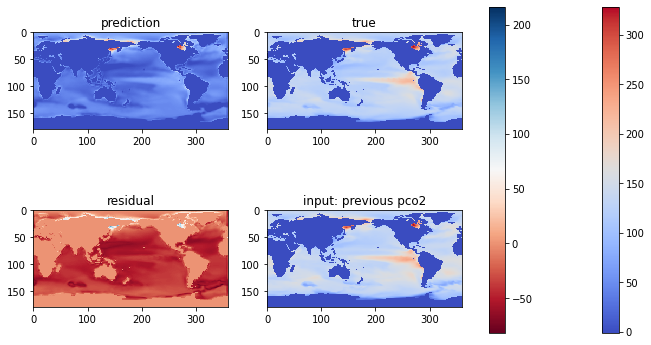

In [7]:
figure, axis = plt.subplots(2, 2,figsize=(12, 6))


img=axis[0][0].imshow(np.flipud(predicted_frames[0][1]),cmap="coolwarm", interpolation="nearest")
axis[0][0].set_title("prediction")
plt.colorbar(img,ax=axis)

img1=axis[0][1].imshow(np.flipud(y[0][1]),cmap="coolwarm", interpolation="nearest")
axis[0][1].set_title("true")

diff=np.flipud(np.squeeze(predicted_frames[0][1]-y[0][1]))
img2=axis[1][0].imshow(diff,cmap="RdBu", interpolation="nearest")
axis[1][0].set_title("residual")
plt.colorbar(img2,ax=axis)


img2=axis[1][1].imshow(np.flipud(X[0][1][:,:,5]),cmap="coolwarm", interpolation="nearest")
axis[1][1].set_title("input: previous pco2")

plt.savefig('../../assets/transfer_nfp.png')

plt.show()

### Inverse

In [8]:
def inverse_scale_image_nfp(arr, df):
    """
    inverse_scale_image(arr, df):
    - inverses the pco2 scaling
    """
    
    old_min = np.nanmin(df)
    old_max = np.nanmax(df)
    y_pred = arr*(old_max-old_min)/255+old_min
    
    tmp=np.nan_to_num(df[X_index][1:])
    y_true=np.expand_dims(tmp,axis=4)
    y_pred[y_true==0]=0
    return y_true,y_pred

In [9]:
chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2 = read_xarray(dir_name)
y_true,y_pred=inverse_scale_image_nfp(predicted_frames,pco2.pCO2.data)  

In [10]:
print("Scaled back whole grid RMSE score:")
np.sqrt(np.mean((y_true[:,:1]-y_pred[:,:1])**2))

Scaled back whole grid RMSE score:


87.06387689866146